<a href="https://colab.research.google.com/github/Joseikwang/Data_Sci_Analysis-50400/blob/main/CEMA_QUIZ_TWO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **East Africa Under Five and Neonatal Mortality Analysis**

# **Step 1: Install and Import Libraries**

First, we need to install and import necessary libraries.

In [ ]:
# Install necessary packages
!pip install geopandas
!pip install matplotlib

# Import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import zipfile
import os

# Make plots prettier
plt.style.use('seaborn-v0_8')


# **Step 2: Load the Dataset**

In [ ]:
# Read CSV, treat all as strings first
df = pd.read_csv('/content/dataset_datascience.csv', dtype=str)

# Convert important columns to numeric
df['Observation Value'] = pd.to_numeric(df['Observation Value'], errors='coerce')
df['Series Year'] = pd.to_numeric(df['Series Year'], errors='coerce')

# Preview the data
df.head()


,REF_AREA,Geographic area,Regional group,Indicator,Sex,Wealth Quintile,Series Name,Series Year,Reference Date,Observation Value,...,Country notes,Observation Status,Unit of measure,Series Type,Series Category,Series Method,Age Group of Women,Time Since First Birth,Definition,Interval
0,AFG,Afghanistan,NaN,Neonatal mortality rate,Total,Total,Afghanistan Health Survey 2018 (Direct),2018.0,1995.5,47.869030,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,Others,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5
1,AFG,Afghanistan,NaN,Neonatal mortality rate,Total,Total,Afghanistan Health Survey 2018 (Direct),2018.0,2000.5,35.349317,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,Others,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5
2,AFG,Afghanistan,NaN,Neonatal mortality rate,Total,Total,Afghanistan Health Survey 2018 (Direct),2018.0,2005.5,27.699219,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,Others,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5
3,AFG,Afghanistan,NaN,Neonatal mortality rate,Total,Total,Afghanistan Health Survey 2018 (Direct),2018.0,2010.5,21.056003,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,Others,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5
4,AFG,Afghanistan,NaN,Neonatal mortality rate,Total,Total,Afghanistan Health Survey 2018 (Direct),2018.0,2015.5,20.167379,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,Others,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5


# **Step 3: Filter for East African Community (EAC) Countries**

List of EAC countries based on official EAC website:

Burundi, Kenya, Rwanda, South Sudan, Tanzania, Uganda, Democratic Republic of the Congo (DRC), and Somalia



In [ ]:
# List of East African Community countries
eac_countries = ['Burundi', 'Kenya', 'Rwanda', 'South Sudan', 'Tanzania', 'Uganda', 'Democratic Republic of the Congo', 'Somalia']

# Filter for only EAC countries
eac_data = df[df['Geographic area'].isin(eac_countries)]

# Also filter for needed indicators
eac_data = eac_data[eac_data['Indicator'].isin(['Under-five mortality rate', 'Neonatal mortality rate'])]

# Check
eac_data.head()


,REF_AREA,Geographic area,Regional group,Indicator,Sex,Wealth Quintile,Series Name,Series Year,Reference Date,Observation Value,...,Country notes,Observation Status,Unit of measure,Series Type,Series Category,Series Method,Age Group of Women,Time Since First Birth,Definition,Interval
6387,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),NaN,1993.5,36.41348,...,NaN,Excluded from IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5
6388,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),NaN,1998.5,41.25996,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5
6389,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),NaN,2003.5,32.83915,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5
6390,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),NaN,2008.5,28.46557,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5
6391,BDI,Burundi,NaN,Neonatal mortality rate,Total,Total,Demographic and Health Survey 2016-2017 (Direct),NaN,2013.5,23.70623,...,NaN,Included in IGME,"Deaths per 1,000 live births",Direct,DHS,Survey/Census with Full Birth Histories,NaN,NaN,NaN,5


**Explanation:**

We subset the datasets to include only the EAC countries we care about.
Printing confirms that filtering worked correctly.

# **Step 4: Prepare Latest Estimates for Mapping**
We'll pick the latest year data for each country and indicator.

In [ ]:
# Find latest year for each country and indicator
latest_entries = eac_data.sort_values('Series Year').groupby(['Geographic area', 'Indicator']).last().reset_index()

# Pivot to get separate columns for each indicator
latest_data = latest_entries.pivot(index='Geographic area', columns='Indicator', values='Observation Value').reset_index()

# Rename for easier use
latest_data.columns = ['Country', 'Neonatal Mortality Rate', 'Under-Five Mortality Rate']

# View
latest_data.head()


,Country,Neonatal Mortality Rate,Under-Five Mortality Rate
0,Burundi,30.760000,100.00
1,Democratic Republic of the Congo,27.470000,104.20
2,Kenya,38.590000,164.00
3,Rwanda,18.645340,50.96
4,Somalia,40.254291,61.40


# **Step 5: Load and Prepare Shapefiles**

In [ ]:
# Unzip the shapefiles
with zipfile.ZipFile('/content/All EAC shape files.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/eac_shapes')

# Combine all shapefiles
eac_shapes = gpd.GeoDataFrame()

for root, dirs, files in os.walk('/content/eac_shapes'):
    for file in files:
        if file.endswith('.shp'):
            path = os.path.join(root, file)
            gdf = gpd.read_file(path)
            eac_shapes = pd.concat([eac_shapes, gdf], ignore_index=True)

# Fix column names
for col in eac_shapes.columns:
    if 'NAME' in col or 'Country' in col:
        eac_shapes = eac_shapes.rename(columns={col: 'Country'})
        break

eac_shapes.head()


,GID_0,COUNTRY,geometry,GID_3,GID_1,Country,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,...,NAME_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,GID_5,NAME_5,TYPE_5,ENGTYPE_5,CC_5
0,RWA,Rwanda,"POLYGON ((29.71332 -2.81759, 29.71295 -2.81774...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BDI,Burundi,"POLYGON ((29.42974 -3.06644, 29.42982 -3.06755...",BDI.1.1.1_1,BDI.1_1,Bubanza,NA,BDI.1.1_1,Bubanza,NA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BDI,Burundi,"POLYGON ((29.32558 -3.08895, 29.32386 -3.09593...",BDI.1.1.2_1,BDI.1_1,Bubanza,NA,BDI.1.1_1,Bubanza,NA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BDI,Burundi,"POLYGON ((29.39401 -3.07621, 29.40118 -3.07594...",BDI.1.1.3_1,BDI.1_1,Bubanza,NA,BDI.1.1_1,Bubanza,NA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BDI,Burundi,"POLYGON ((29.40189 -3.05728, 29.40113 -3.0565,...",BDI.1.1.4_1,BDI.1_1,Bubanza,NA,BDI.1.1_1,Bubanza,NA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("COUNTRY column:", eac_shapes['COUNTRY'].unique())
print("Country column:", eac_shapes['Country'].unique())


COUNTRY column: ['Rwanda' 'Burundi' 'Uganda' 'South Sudan' 'Somalia' 'Tanzania' 'Kenya'
 'Democratic Republic of the Congo']
Country column: [nan 'Bubanza' 'Bujumbura Mairie' 'Bujumbura Rural' 'Bururi' 'Cankuzo'
 'Cibitoke' 'Gitega' 'Karuzi' 'Kayanza' 'Kirundo' 'Makamba' 'Muramvya'
 'Muyinga' 'Mwaro' 'Ngozi' 'Rutana' 'Ruyigi' 'Central Equatoria'
 'Eastern Equatoria' 'Jungoli' 'Lakes' 'North Bahr-al-Ghazal' 'Unity'
 'Upper Nile' 'Warap' 'West Bahr-al-Ghazal' 'West Equatoria' 'Awdal'
 'Bakool' 'Banaadir' 'Bari' 'Bay' 'Galguduud' 'Gedo' 'Hiiraan'
 'Jubbada Dhexe' 'Jubbada Hoose' 'Mudug' 'Nugaal' 'Sanaag'
 'Shabeellaha Dhexe' 'Shabeellaha Hoose' 'Sool' 'Togdheer'
 'Woqooyi Galbeed' 'Arusha' 'Dar es Salaam' 'Dodoma' 'Geita' 'Iringa'
 'Kagera' 'Kaskazini Pemba' 'Kaskazini Unguja' 'Katavi' 'Kigoma'
 'Kilimanjaro' 'Kusini Pemba' 'Kusini Unguja' 'Lindi' 'Manyara' 'Mara'
 'Mbeya' 'Mjini Magharibi' 'Morogoro' 'Mtwara' 'Mwanza' 'Njombe' 'Pwani'
 'Rukwa' 'Ruvuma' 'Shinyanga' 'Simiyu' 'Singida' 'Son

In [ ]:
print("Mortality dataset countries:", latest_data['Country'].unique())


Mortality dataset countries: ['Burundi' 'Democratic Republic of the Congo' 'Kenya' 'Rwanda' 'Somalia'
 'South Sudan' 'Uganda']


**Explanation:**

- We load African countries' boundaries.
- We check the available names to make sure they match exactly (sometimes country names differ slightly).

# **Step 6: Merge Data with Shapefiles**

Join mortality estimates with the shapefile to prepare for mapping

In [ ]:
# 1. Clean spaces
eac_shapes['COUNTRY'] = eac_shapes['COUNTRY'].str.strip()
latest_data['Country'] = latest_data['Country'].str.strip()

# 2. Merge properly
gdf = eac_shapes.merge(latest_data, left_on='COUNTRY', right_on='Country')

# 3. Check results
print(gdf.head())
print(f"Merged dataset has {gdf.shape[0]} rows")


  GID_0  COUNTRY                                           geometry  \
0   RWA   Rwanda  POLYGON ((29.71332 -2.81759, 29.71295 -2.81774...   
1   BDI  Burundi  POLYGON ((29.42974 -3.06644, 29.42982 -3.06755...   
2   BDI  Burundi  POLYGON ((29.32558 -3.08895, 29.32386 -3.09593...   
3   BDI  Burundi  POLYGON ((29.39401 -3.07621, 29.40118 -3.07594...   
4   BDI  Burundi  POLYGON ((29.40189 -3.05728, 29.40113 -3.0565,...   

         GID_3    GID_1 Country_x NL_NAME_1      GID_2   NAME_2 NL_NAME_2  \
0          NaN      NaN       NaN       NaN        NaN      NaN       NaN   
1  BDI.1.1.1_1  BDI.1_1   Bubanza        NA  BDI.1.1_1  Bubanza        NA   
2  BDI.1.1.2_1  BDI.1_1   Bubanza        NA  BDI.1.1_1  Bubanza        NA   
3  BDI.1.1.3_1  BDI.1_1   Bubanza        NA  BDI.1.1_1  Bubanza        NA   
4  BDI.1.1.4_1  BDI.1_1   Bubanza        NA  BDI.1.1_1  Bubanza        NA   

   ... ENGTYPE_4 CC_4 GID_5 NAME_5 TYPE_5 ENGTYPE_5 CC_5 Country_y  \
0  ...       NaN  NaN   NaN    NaN    Na

In [ ]:
# 1. Drop duplicated countries based on COUNTRY
gdf_country = gdf.drop_duplicates(subset=['COUNTRY'])

# 2. Now you can plot nicely!
print(gdf_country[['COUNTRY', 'Neonatal Mortality Rate', 'Under-Five Mortality Rate']])


                               COUNTRY  Neonatal Mortality Rate  \
0                               Rwanda                18.645340   
1                              Burundi                30.760000   
2662                            Uganda                33.615540   
2663                       South Sudan                41.858952   
2712                           Somalia                40.254291   
2786                             Kenya                38.590000   
9847  Democratic Republic of the Congo                27.470000   

      Under-Five Mortality Rate  
0                         50.96  
1                        100.00  
2662                     133.00  
2663                     365.60  
2712                      61.40  
2786                     164.00  
9847                     104.20  


**Explanation:**

We combine the mortality data into the map layer based on the country names to visualize later.

# **Step 7: Plot Maps of Mortality Rates**

First for under-five, then for neonatal.

# (a) Under-Five Mortality Map



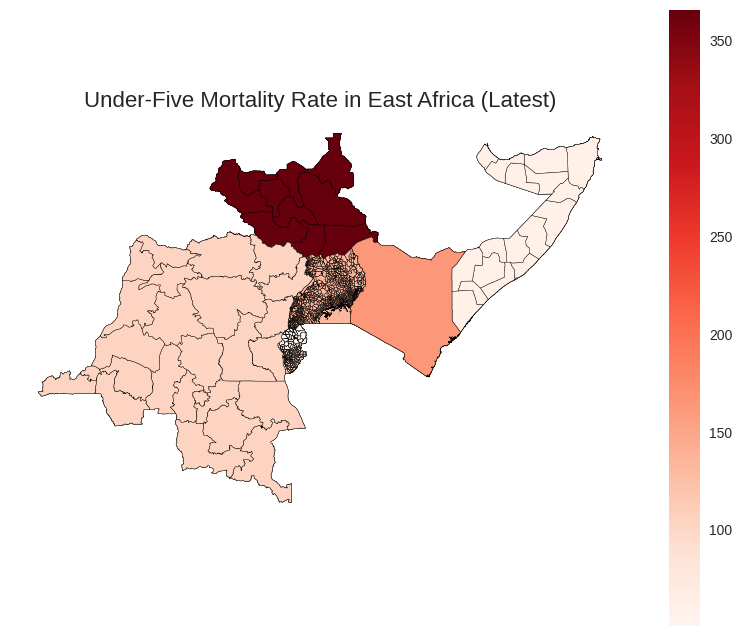

In [ ]:

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='Under-Five Mortality Rate', cmap='Reds', legend=True, edgecolor='black', ax=ax)
ax.set_title('Under-Five Mortality Rate in East Africa (Latest)', fontsize=16)
plt.axis('off')
plt.show()


# (b) Neonatal Mortality Map

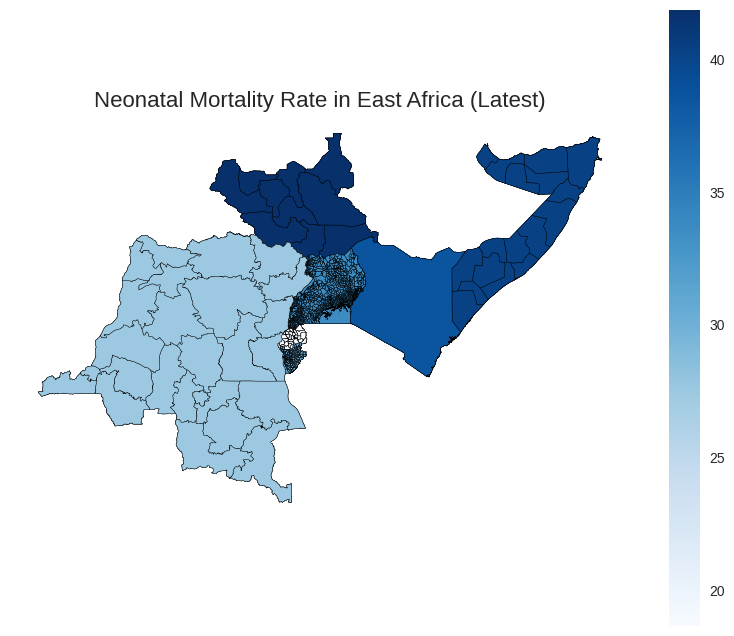

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='Neonatal Mortality Rate', cmap='Blues', legend=True, edgecolor='black', ax=ax)
ax.set_title('Neonatal Mortality Rate in East Africa (Latest)', fontsize=16)
plt.axis('off')
plt.show()


**Explanation:**

We create choropleth maps coloring each country based on their mortality rate, using a color scale (Reds and Blues)

# **Step 8: Prepare Trends Data Over Time**
For both indicators

In [ ]:
# Separate datasets
underfive_df = eac_data[eac_data['Indicator'] == 'Under-five mortality rate']
neonatal_df = eac_data[eac_data['Indicator'] == 'Neonatal mortality rate']

# Pivot
underfive_trends = underfive_df.pivot_table(index='Series Year', columns='Geographic area', values='Observation Value')
neonatal_trends = neonatal_df.pivot_table(index='Series Year', columns='Geographic area', values='Observation Value')

# Check
underfive_trends.head()


Geographic area,Burundi,Democratic Republic of the Congo,Kenya,Rwanda,Somalia,South Sudan,Uganda
Series Year,,,,,,,
1965.0,240.156500,NaN,NaN,NaN,NaN,NaN,NaN
1969.0,NaN,NaN,204.166667,NaN,NaN,NaN,223.666667
1970.0,244.578889,NaN,NaN,197.333333,NaN,NaN,NaN
1973.0,NaN,NaN,NaN,NaN,NaN,284.433333,NaN
1977.0,NaN,NaN,158.166667,NaN,NaN,NaN,NaN


# **Step 9: Plot Mortality Trends**
Now,we plot average trends with country-level points for each indicator
# (a) Under-Five Mortality Trend

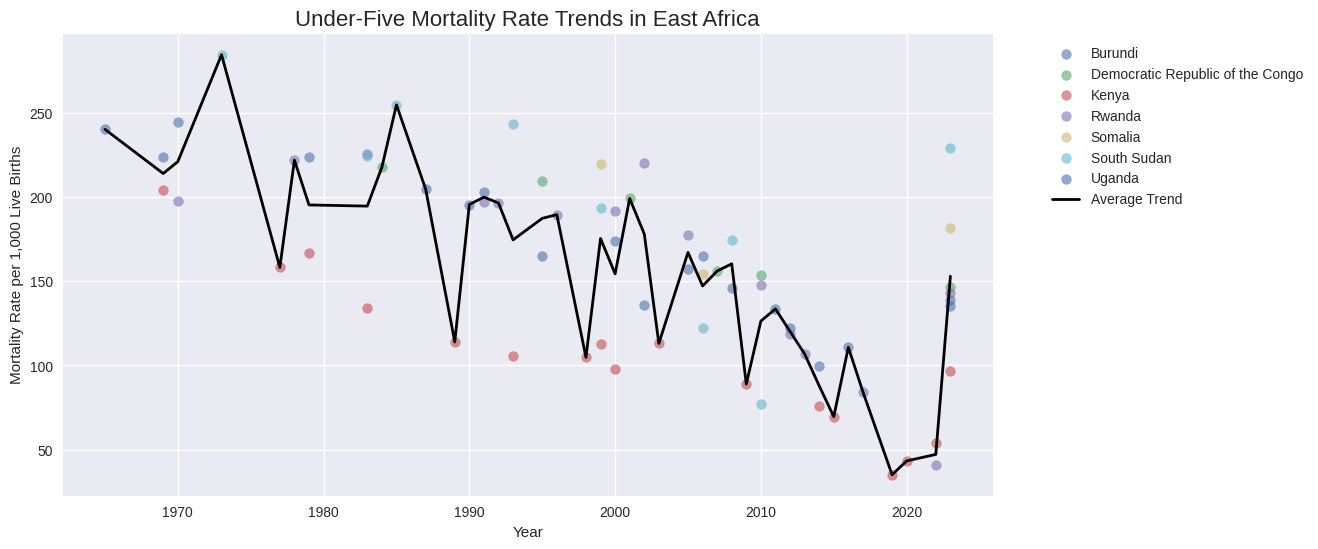

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter country points
for country in underfive_trends.columns:
    ax.scatter(underfive_trends.index, underfive_trends[country], label=country, alpha=0.6)

# Plot average trend
avg_underfive = underfive_trends.mean(axis=1)
ax.plot(avg_underfive.index, avg_underfive.values, color='black', linewidth=2, label='Average Trend')

ax.set_title('Under-Five Mortality Rate Trends in East Africa', fontsize=16)
ax.set_xlabel('Year')
ax.set_ylabel('Mortality Rate per 1,000 Live Births')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# (b) Neonatal Mortality Trend

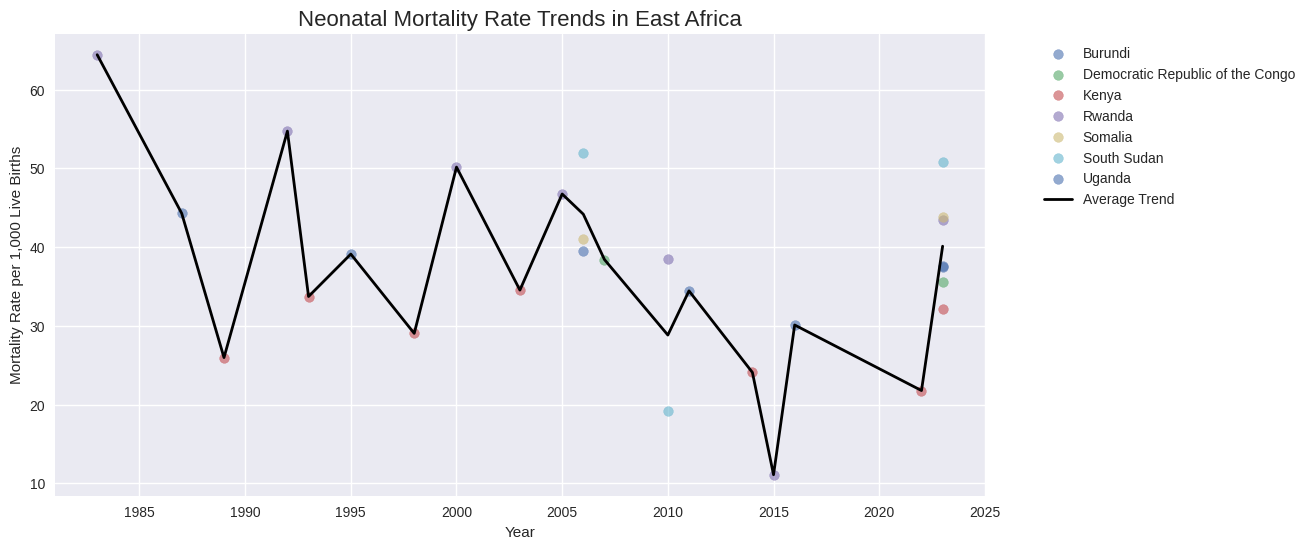

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter country points
for country in neonatal_trends.columns:
    ax.scatter(neonatal_trends.index, neonatal_trends[country], label=country, alpha=0.6)

# Plot average trend
avg_neonatal = neonatal_trends.mean(axis=1)
ax.plot(avg_neonatal.index, avg_neonatal.values, color='black', linewidth=2, label='Average Trend')

ax.set_title('Neonatal Mortality Rate Trends in East Africa', fontsize=16)
ax.set_xlabel('Year')
ax.set_ylabel('Mortality Rate per 1,000 Live Births')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Explanation:**

- Scatter points represent country-level yearly estimates.

- The black line shows the average trend across all EAC countries.



# **Step 10: Identify Countries with Highest Mortality**

In [ ]:
# Find highest Under-Five
highest_underfive = latest_data.sort_values(by='Under-Five Mortality Rate', ascending=False).head(1)

# Find highest Neonatal
highest_neonatal = latest_data.sort_values(by='Neonatal Mortality Rate', ascending=False).head(1)

print("Country with highest Under-Five Mortality Rate:")
print(highest_underfive)

print("\nCountry with highest Neonatal Mortality Rate:")
print(highest_neonatal)


Country with highest Under-Five Mortality Rate:
       Country  Neonatal Mortality Rate  Under-Five Mortality Rate
5  South Sudan                41.858952                      365.6

Country with highest Neonatal Mortality Rate:
       Country  Neonatal Mortality Rate  Under-Five Mortality Rate
5  South Sudan                41.858952                      365.6
